В данной статье описана архитектура "трансформер", которая получила широкое распространение в задачах NLP, а в последние годы и в компьютерном зрении.

Существует два основных варианта трансформера: энкодер+декодер, либо только энкодер. Мы разберем оба варианта. Трансформер - это довольно замысловатый механизм, который не получится понять "с наскока". Его нужно изучать постепенно.

## Общее устройство транформера

### Задача, решаемая трансформером

Трансформер, состоящий из энкодера и декодера, решает задачу преобразования последовательности в последовательность (**sequence to sequence**, seq2seq). Последовательности могут быть разнообразными, но чаще всего трансформер применяется к задаче обработки текста. Типичная задача - машинный перевод текста с одного языка на другой.

Сначала текст разбивается на токены (это могут быть слова целиком, части слов или отдельные буквы, в зависимости от конкретной реализации). Затем токены преобразуются в вектора-эмбеддинги. Подробнее о том, что такое вектора-эмбеддинги и откуда они берутся, можно почитать в [курсе NLP от Лены Войты](https://lena-voita.github.io/nlp_course/word_embeddings.html) (там же, кстати, можно найти и про [трансформеры](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html#transformer_intro)). Текст, преобразованный в эмбеддинги, является массивом данных с тремя осями. Как обычно, Первая ось отвечает за номер примера в батче. Вторая ось отвечает за номер токена, а третья ось за позицию в эмбеддинге (индекс внутри вектора-эмбеддинга). Это общий принцип работы с текстом, который применяется не только в трансформерах, но и в рекуррентных сетях (RNN).

Таким образом, **трансформер работает с последовательностями векторов**, то есть с массивами чисел с тремя осями: номер примера в батче, номер вектора в последовательности и позиция внутри вектора. Ниже приведена схема архитектуры трансформер. Между блоками по стрелкам передаются последовательности векторов.

<img src="assets/transformer.jpg" width="800" align="center">

Начнем поэтапно изучать эту архитектуру. Трансформер состоит из **энкодера** (синий) и **декодера** (оранжевый). Обе эти части состоят из последовательности блоков, притом в энкодере эти блоки устроены несколько проще, а в декодере несколько сложнее.

### Блоки трансформера

Пока что мы будем рассматривать блок трансформера как "черный ящик", не заглядывая внутрь. "Под капотом" этого блока - скалярное произведение, взвешенное среднее, матричное умножение и другие преобразования, но это мы расмотрим позже. Сейчас важно понять какими в целом свойствами обладает этот блок. Он принимает и возвращает последовательность векторов равной длины. Блок трансформера обладает свойством **эквивариантности к перестановкам**. Это означает, что если осуществить перестановку элементов входной последовательности, то элементы выходной последовательности окажутся переставлены таким же образом, и больше никак не изменятся. Иными словами, порядок следования элементов влияет лишь на порядок следования результатов и больше ни на что. Это означает, что блок трансформера *работает с последовательность входных векторов как с неупорядоченным множеством*.

Можно провести аналогию: в школьный класс попадают ребята с разным характером и в процессе общения оказывают друг на друга так, что характеры меняются. В итоге каждый из ребят становится слегка не тем, кем был, а может и полностью измениться. Ребят в классе можно как-то упорядочить, например по имени, но по существу они являются неупорядоченным множеством. Так же и внутри блока трансформера вектора как бы "обмениваются информацией" и при этом изменяются.

Блок трансформера может обрабатывать последовательность векторов произвольной длины. Это важно для машинного перевода, где длина переводимого текста может быть разной.

### Энкодер трансформера

Энкодер состоит из последовательно соединенных блоков трансформера. В оригинальной статье предлагается использовать 6 блоков, но в более современных трансформерах их число доходит до 96. Энкодер принимает на вход вектора-эмбеддинги входных токенов, то есть векторные представления тех слов, которые надо перевести (на positional encoding пока не смотрим, о нем далее). Возвращает энкодер также набор векторов, который называется **sentence representation**. Это массив данных, в котором закодирована информация о входной последовательности, то есть смысл переводимого текста. Эта информация затем передается в декодер.

До появления трансформеров в задачах seq2seq использовались в основном рекуррентные сети (RNN). Они также состоят из энкодера и декодера, но их слабое место в том, что из энкодера в декодер передавался вектор фиксированной длины. Если текст, который нужно перевести, очень длинный, то сеть может не справиться с задачей уместить всю информацию о тексте в этот вектор, в итоге качество перевода ухудшается с увеличением размера входного текста (хотя ничего не мешает разбить текст на предложения и переводить их отдельно). Трансформеры в этом плане являются шагом вперед. В них sentence representation, как видно из схемы, является последовательностью векторов такой же длины, что и входная последовательность. То есть чем длиннее входные данные, тем больший размер имеет массив sentence representation и тем больше информации может уместить.

Важно отметить, что в энкодере (а также и в декодере) веса всех блоков разные, то есть это не один и тот же блок, применяемый несколько раз (как в RNN), а разные блоки с разной инициализацией весов.

### Позиционное кодирование

Если каждый блок трансформера эквивариантен к перестановкам, то и весь энкодер в целом также эквивариантен к перестановкам. Однако в тексте порядок слов может влиять на смысл текста. Если перестановка слов приведет лишь к перестановке соответствующих выходов декодера, то это говорит о том, что вряд ли энкодер извлекает смысл текста.

Это серьезная проблема, и авторы находят ей решение. К массиву векторов, подаваемому на вход энкодеру, прибавляются слагаемые по определенному правилу. Авторы предлагают два варианта:

*Вариант 1*. Каждому *номеру* элемента последовательности ставится в соответствие обучаемый вектор, называемый позиционным эмбеддингом. Если, например, эмбеддинги слов имели длину 300, а максимально допустимая длина входной последовательности - 1024, то создается массив чисел размером 1024x300 и инициализируется случайными значениями. Когда на вход подается последовательность векторов, то *к i-му вектору прибавляется эмбеддинг i-й позиции*. Позиционные эмбеддинги обучаются вместе со всей остальной нейросетью.

У этого варианта есть недостаток: длина входной последовательности становится ограниченной. Слишком длинную последовательность трансформер обработать не сможет, так как не хватит позиционных эмбеддингов. Есть и второй недостаток: если максимальную длину мы зададим равной 1024, то входные последовательности длиной 1000+ будут встречаться редко, поэтому и веса соответствующих позиционных эмбеддингов будут обновляться редко, из-за чего они могут плохо обучиться.

*Вариант 2*. Мы точно так же создаем позиционные эмбеддинги, но заполняем их синусоидами с разным периодом и делаем необучаемыми (замораживаем веса):

<img src="assets/transformer7.png" width="800" align="center">

Изображение взято из [данного источника](https://erdem.pl/2021/05/understanding-positional-encoding-in-transformers), там же можно почитать подробнее про позиционное кодирование. Кажущийся больший период синусоиды с левой стороны изображения обусловлен стробоскопическим эффектом.

Авторы сравнили эти два подхода экспериментально и они дали приблизительно равную точность сети на валидации, то есть можно выбирать любой из них. Авторы предлагают выбирать вариант с сигусоидами, поскольку в нем нет ограничения на длину последовательности.

### Принцип обучения трансформера

Понять устройство декодера (masked transformer block) будет проще, если мы сначала рассмотрим как обучается трансформер. Обучается он, как обычно, градиентным спуском. Для простоты возьмем размер батча равный единице. Пусть на очередном шаге градиентного спуска мы имеем пару из исходных данных (предложение на английском) и целевых данных (перевод на русский). Исходные данные переводятся в эмбеддинги, складываются с позиционными эмбеддингами и пропускаются через энкодер. Мы получаем последовательность выходных векторов (sentence representation), которая должна кодировать смысл текста.

Декодер при этом обучается осуществлять следующее преобразование:

<img src="assets/transformer2.jpg" width="800" align="center">

Декодер также является последовательностью блоков трансформера (с некоторыми мофикациями, о которых далее), поэтому длины входной и выходной последовательностей в декодере должны сопадать, что и видно на схеме. START и END - это специальные токены, которые тоже имеют свои эмбеддинги. Несмотря на то, что в схеме много стрелок, вся последовательность преобразуется декодером за один проход. Стрелки означают лишь соответствие между словами.

Здесь важно отметить, что речь идет об *обучении*, поэтому у нас в распоряжении есть верный ответ, который мы подаем на вход декодеру. Но тогда кажется, что задача декодера тривиальна. Зачем ему вообще нужна информация из энкодера, если верный ответ уже передан на вход, и нужно просто передать его на выход, сдвинув слова влево? И действительно, в таком виде архитектура вряд ли сможет обучиться переводить текст. Для обучения нам нужно маскирование.

### Маскирование в декодере

Декодер, как и энкодер, состоит из последовательности блоков. Вспомним, что в обычном трансформер-блоке (без маскирования) все входные вектора влияют на все выходные вектора. **При использовании маскирования i-й входной вектор перестает оказывать влияние на все выходные вектора от 0-го до (i-1)-го.** Это означает, что на схеме информация не может распространяться влево (от конца к началу текста), и для любого i первые i выходных векторов однозначно определяются первыми i входными векторами. При этом, конечно, теряется свойство эквивариантности к перестановкам. 

Например, слово "что" стоит на 4-й позиции. При проходе через первый блок декодера (которых всего 6) первые 3 выходных вектора не будут никак зависеть от слова "что". Например, если мы изменим эмбеддинг этого слова, то первые три вектора никак не изменятся. Весь декодер - это 6 последовательных блоков, поэтому для всего декодера в целом верен тот же принцип. А значит для предсказания слова "все" на выходе декодер не сможет использовать входное слово "все", а сможет использовать только слова "<START> Я смею" и информацию из энкодера, извлеченную из английского текста. Задача обучения для декодера перестает быть тривиальной.
    
### Использование информации из энкодера
    
Блок трансформера в энкодере принимал на вход последовательность векторов и возвращал последовательность такой же длины. Если декодер был бы устроен так же, то как он смог бы использовать еще и информацию из энкодера? Никак, поэтому блок декодера, помимо маскирования, имеет еще одно отличие от блока энкодера. Блок декодера принимает на вход сразу две последовательности векторов: одну с "нижнего уровня" декодера и другую из энкодера. Эти последовательности могут иметь разную длину. Возвращает же декодер последовательность длиной равной той, что взята с "нижнего уровня".
    
### Инференс
    
Если при обучении мы сразу имеем эталонный ответ, который можем передать на вход декодеру, то как мы будем поступать при инференсе, то есть когда нам нужно перевести неивестную фразу? Мы делаем таким образом. Сначала мы обрабатываем фразу энкодером и получаем для нее внутренние представления. Затем на вход декодеру мы подаем только слово START. На выходе мы получаем первое слово перевода, допустим "Я". Затем на вход мы подаем слова [START, Я] и получаем выход [Я, смею]. Затем подаем на вход слова [START, Я, смею] и так далее, пока не получим слово END.
    
Получается, что во время инференса декодер работает в рекуррентном режиме, а при обучении нерекурретно (параллельно). Возможно именно поэтому он назван "трансформером" - потому что трансформируется из паралелльного режима в рекуррентный. Обучение в параллельном режиме дает огромный прирост производительности при обучении, по сравнению с RNN.
    
Зато складывается ощущение, что во время инференса трансформер работает очень мелленно - ведь он запускается столько раз, сколько слов в переводе. Однако это не совсем так. Вспомним про маскирование: информация не передается в декодере от конца к началу. Поэтому при каждом следующем слове нам не нужно пересчитывать все, что посчитал декодер ранее - ведь информация назад не распространяется! Поэтому общий объем необходимых вычислений остается таким же, как при обучении.

<img src="assets/transformer3.jpg" width="800" align="center">

## Устройство блока трансформера

Как мы ранее обсуждали, блок энкодера принимает и возвращает последовательность векторов произвольной длины и имеет свойство перестановочной эквивариантности (порядок следования элементов влияет лишь на порядок следования результатов). Далее поэтапно разберем внутреннее устройство такого блока, начав с механизма внимания.

### Dot-product attention

Механизм "внимания" (attention) был впервые описан в статье [Neural Machine Translation by Jointly Learning to Align and Translate]($Neural Machine Translation by Jointly Learning to Align and Translate$) (D. Bahdanau, K. Cho, Y. Bengio, 2014), и с тех пор было предложено много его вариантов. Рассмотрим этот механизм сначала в общем виде.

Пусть мы имеем вектор $Q$ и множество векторов $\{V_i\}$. Размер множества $\{V_i\}$ может быть переменным, и известно, что некоторые векторы из $\{V_i\}$ имеют большее отношение к $Q$, чем другие. Например, $Q$ может быть эмбеддингов одного из слов в тексте, а $\{V_i\}$ - эмбеддинги всех остальных слов. Мы выполняем с этими данными следующее преобразование:

1. Для каждого вектора $V_i$ считаем число $S_i = score(Q, V_i)$, описывающее степень его релевантности $Q$.
2. К полученным числам применяем операцию softmax, получая веса: $W_0, W_1, \ldots, W_n = softmax(S_1, S_2, \ldots, S_n)$.
3. Считаем взвешенное среднее элементов $\{V_i\}$, используя веса $\{W_i\}$: $V = W_0V_0 + W_1V_1 + \ldots + W_nV_n$.

Вектор $V$ и является нашим результатом. По задумке он аккумулирует в себе информацию об элементах из $\{V_i\}$, наиболее релевантных вектору $Q$, который называется "контекстом", или "запросом" (**query**). Таким образом, механизм внимания - это преобразование, которое принимает на вход данные переменного размера и возвращает вектор фиксированного размера.

Функция $score$ может быть обучаемой или фиксированной. В самом простом случае это скалярное произведение: $score(Q, V_i) = Q \cdot V_i$. Такой вариант называется **dot product attention**, и именно он используется в трансформерах. Часто скалярное произведение неформально описывается как мера сходства двух векторов, однако это не совсем так. Более точным будет утвердение, что скалярное произведеение - это величина проекции вектора $V_i$ на направление, задаваемое вектором $Q$, умноженная на длину $Q$.

В более общем случае вместо множества векторов $\{V_i\}$ мы можем иметь множества пар ключ-значение: $\{K_i\}$ и $\{V_i\}$. В этом случае для сравнения с запросом $Q$ мы используем ключи $\{K_i\}$, получаем веса и с их помощью считаем средневзвешенное значений $\{V_i\}$:

1. Для каждого ключа $K_i$ считаем число $S_i = score(Q, K_i)$, описывающее степень его релевантности запросу $Q$.
2. К полученным числам применяем операцию softmax, получая веса: $W_0, W_1, \ldots, W_n = softmax(K_1, K_2, \ldots, K_n)$.
3. Считаем взвешенное среднее элементов $\{V_i\}$, используя веса $\{W_i\}$: $V = W_0V_0 + W_1V_1 + \ldots + W_nV_n$.

Предыдущий алгоритм является частным случаем, когда $K_i = V_i$.

### Scaled dot-product attention

С увеличением размерности векторов $Q$ и $\{K_i\}$ их скалярное произведение (стреднестатистически) также начинает расти. Например, если случайные величины $Q$ и $K$ являются векторами длины $L$, элементы которых имеют [i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) распределение $\mathcal{N}(0, 1)$, то их скалярное произведение имеет распределение $\mathcal{N}(0, L)$, то есть дисперсия тем выше, чем больше длина векторов. А как известно, функция softmax чувствительна к масштабу входных данных. Если входные данные имеют сильно отличающиеся друг от друга значения, то на выходе softmax вероятно будут числа, близкие и единице и нулям, и производные результата по входам будет стремиться к нулю. Это мешает обучению ("проблема затухающих градиентов").

Для избавления от этой проблемы авторы предлагают домножать $S_i$ на квадратный корень из размерности вектора $Q$:

$L = dim(Q)$

$S_i = \cfrac{score(Q, K_i)}{\sqrt{L}}$

Такая модификация называется scaled dot-product attention и используется в трансформерах.

<img src="assets/transformer4.jpg" width="800" align="center">

$Attention(Q, K, V) = softmax \bigg( \cfrac{QK^T}{\sqrt{dim(K)}} \bigg) V$

**Резюме:** на основании степени "сходства" (по скалярному произведению) ключей $\{K_i\}$ с запросом $Q$ рассчитываются веса $\{W_i\}$, которые означают релевантность векторов $\{V_i\}$ запросу. Затем считается взвешенное среднее векторов $\{V_i\}$ с использованим этих весов.

### Multi-query dot-product attention

Для одного и того же множества $\{K_i\}$, $\{V_i\}$ мы можем по очереди использовать несколько векторов $Q$ и получить несколько результатов. Обозначим описанное на схеме выше преобразование как `single_query_attention(Q, K, V)`. Тогда преобразование для несколько векторов $Q$ можно записать таким псевдокодом:

```
function multi_query_attention(Queries, Keys, Values):
    for i in [0, ..., L-1]:
        Outputs[i] = single_query_attention(Queries[i], Keys, Values)
    Возвращаем массив Outputs
 ```
 
То есть мы применяем механизм внимания N раз, по очереди используя каждый из векторов как контекст. Ниже приводится пример того, как на Python можно запрограммировать Scaled Dot Product Attention. Код вычислительно не оптимизирован, приводится лишь для примера.

In [27]:
import numpy as np
from scipy.special import softmax

def single_query_attention(query, keys, values):
    S = np.array([(k*query).sum() for k in keys])  # scalar product
    S /= np.sqrt(len(query)) # scaling
    W = softmax(S)
    result = np.average(values, axis=0, weights=W) # weighted mean
    return result

def multi_query_attention(queries, keys, values):
    return np.array([single_query_attention(q, keys, values) for q in queries])

# check
queries = np.random.rand(20, 256)
keys = np.random.rand(50, 256)
values = np.random.rand(50, 512)
assert multi_query_attention(queries, keys, values).shape == (20, 512)

В качестве частного случая мы можем передать одну и ту же последовательность и в качестве $Q$, и в качестве $K$, и в качестве $V$:

In [ ]:
outputs = multi_query_attention(inputs, inputs, inputs)

Таким образом, multi-query dot-product attention принимает на вход три последовательности векторов:

- **Queries** длиной $L_q$ и размерностью $D_q$
- **Keys** длиной $L_v$ и размерностью $D_q$
- **Values** длиной $L_v$ и размерностью $D_v$

И возвращает последовательность векторов длиной $L_q$ и размерностью $D_v$. При этом векторы либо "обмениваются информацией" друг с другом (если $Q = V$), либо обновляются под действием информации извне (если $Q \neq V$).

*Примечание. Понятие "multi-query attention" не общепринято и используется лишь в данном обзоре для понятности.*

### Masked attention

Допустим мы передаем в Scaled Dot Product Attention одну и ту же последовательность и в качестве $Q$, и в качестве $K$, и в качестве $V$. Маскирование заключается в том, что на i-м шаге (то есть работая с $Q_i$) мы используем только первые $i$ векторов из $K$ и $V$:

In [30]:
def multi_query_attention(queries, keys, values, is_masked=False):
    if is_masked:
        assert np.array_equal(queries, values)
        assert np.array_equal(keys, values)
        return np.array([
            single_query_attention(q, keys[:i+1], values[:i+1])
            for i, q in enumerate(queries)
        ])
    else:
        return np.array([
            single_query_attention(q, keys, values)
            for q in queries
        ])

# check
inputs = np.random.rand(20, 512)
assert multi_query_attention(inputs, inputs, inputs, is_masked=True).shape == inputs.shape

Вместо того, чтобы использоватьв Masked Attention только первые $i$ векторов из $K$ и $V$, мы можем использовать все вектора, но часть посчитанных скалярных произведений заменять на минус бесконечность. После применения softmax соответствующие им веса будут нулевыми. Два варианта, показанные на схеме ниже, идентичны.

<img src="assets/transformer9.jpg" width="700" align="center">

Вычислительно эффективная реализация Dot Product Attention использует матричное умножение, при котором считаются попарные скалярные произведения между всеми векторами из $Q$ и $K$. После этого на результат накладывается маска, согласно которой часть скалярных произведений заменяется на минус бесконечность. После применения softmax минус бесконечность становится нулем.

Таким образом, **маскирование "запрещает" некоторые связи между входными векторами**. В декодере трансформера маскирование используется для того, чтобы последующие входные вектора не оказывали влияния на предыдущие выходные (auto-regressive property). Но маскирование может иметь и более широкое применение. Например, с его помощью можно ограничить связи между отдаленными элементами последовательности (как на второй иллюстрации ниже). Эта тема будет еще раз затронута ниже в разделе "Обсуждение архитектуры".

<img src="assets/transformer10.jpg" width="700" align="center">

### Multi-head attention

Авторы трансформера предлагают еще одну модификацию этой операции: multi-head attention. Вместо одного блока Attention предлагается использовать несколько параллельно работающих блоков, результаты которых конкатенируются. Сам по себе блок multi-query attention не имеет обучаемых параметров, и использование нескольких параллельно работающих блоков, принимающих одни и те же данные, бессмысленно: все блоки будут работать идентично. Поэтому для каждого блока ("головы") и каждого входа создается обучаемое линейное преобразование.

<img src="assets/transformer5.jpg" width="800" align="center">

Слой *"Linear (axis=-1)"* на схеме означает следующее: мы создаем линейный (полносвязный) слой без функции активации, преобразующий $N_1$ чисел в $N_2$ чисел. Этот слой обрабатывает каждый вектор в последовательности независимо.

Конкатенация *"Concat (axis=-1)"* соединяет вектора по оси размерности, то есть, например, первый вектор результирующей последовательности равен склейке первого вектора из каждой головы.

Авторы предлагают использовать 8 голов, а значит нужно создать 24 обучаемых линейных преобразования, плюс еще одно, выполняемое после конкатенации. Смысл линейных преобразований не только в том, что они позволяют блокам работать по-разному, но и в том, что они сокращают размерность векторов. Авторы предлагают использовать $N_1$=512 и $N_2$=64. После конкатенации мы снова получаем вектора размерностью 512.

### Блоки трансформера

<img src="assets/transformer6.jpg" width="1000" align="center">

В **блоке энкодера** мы применяем Multi-Head Attention, подставляя входную последовательность и в качестве $Q$, и в качестве $K$, и в качестве $V$. Таким образом, каждый вектор входной последовательности по очереди "смотрит" на другие вектора и обновляется под их воздействием. Вокруг Multi-Head Attention проброшена связь (residual connection):

`outputs = inputs + Dropout(MultiHeadAttention(inputs))`

Skip connections стали активно использовать после появления сети [ResNet]($Deep Residual Learning for Image Recognition$), где была продемонстрирована их эффективность. Наличие skip connection, проброшенного вокруг некоего блока, означает, что этот блок работает "аддитивно", то есть добавляет результаты своих вычислений к массиву данных и тем самым "корректирует" его, вместо того, чтобы полностью изменять массив данных. Сам блок при этом называется resudial block (остаточный блок). Есть [работа]($Residual Networks Behave Like Ensembles of Relatively Shallow Networks$), в которой показывается, что сеть со skip connections эквивалентна ансамблю менее глубоких сетей.

Слой [LayerNormalization]($Layer Normalization$) нормализует каждый вектор по отдельности. Это можно записать на python следующим образом:

In [1]:
def layer_normalization(inputs):
    means = inputs.mean(axis=-1, keepdims=True)
    stds = inputs.std(axis=-1, keepdims=True)
    return (inputs - means) / stds

Также опционально Layer Normalization может содержать обучаемый масштаб и смещение, как описано [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).

После LayerNormalization в блоке энкодера находится Feed forward network: два линейных слоя с ReLU между ними, которые тоже обрабатывают каждый вектор независимо. Это можно представить также как свертку 1х1. Вектор длиной 512 превращается в вектор длиной 2048 после первого слоя, и снова в вектор длиной 512 после второго слоя. Вокруг Feed forward network тоже проброшен residual connection. Далее снова идет слой LayerNormalization.

В более новой [работе]($On Layer Normalization in the Transformer Architecture$) предлагается помещать слои LayerNormalization внутрь resudial блоков, то есть после линейного слоя и до суммирования, что делает обучение более стабильным.

В каждом residual-блоке перед суммированием применяется dropout с rate=0.1. Также dropout применяется перед первым блоком в энкодере и декодере.

**Блок декодера** отличается от блока энкодера двумя особенностями. Во-первых, в нем применяется Multi-Head Attention с маскированием. Во-вторых следом применяется еще один Multi-Head Attention, в котором в качестве keys и values используется последовательность векторов, полученная из энкодера. Получается, что сначала вектора "смотрят" друг на друга и обмениваются информацией, а затем "смотрят" на выход энкодера и получают из него информацию.

### Выходной слой декодера

Последний блок декодера возвращает последовательность векторов. Каждый вектор нужно каким-то образом преобразовать в слово. Вспомним, что на входе сети у нас есть матрица эмбеддингов, которая сопоставляет вектор каждому слову из словаря. Если какой-либо из выходных векторов мы умножим на эту матрицу, а затем применим argmax (как в задаче классификации), то мы найдем слово, эмбеддинг которого имеет с данным вектором наибольшее скалярное произведение. Это слово мы и будем считать выходным.

Таким образом, каждый вектор, полученный на выходе декодера, умножается на матрицу эмбеддингов. Это означает добавление нового линейного слоя, который имеет общие веса (shared weights) с матрицей эмбеддингов. В результате мы получаем вектора, длина которых равна размеру словаря. Применив softmax, мы получим вероятности слов. Применим argmax, получим наиболее вероятное слово.

На этом рассмотрение архитектуры трансформера можно считать завершенным.

### Обучение

Авторы обучали трансформер на задаче машинного перевода (English-German, English-French), объединяя в батчи примеры с примерно равной длиной. Использовался оптимизатор Adam, рост learning rate в течение первых 4000 шагов, затем полиномиальное затухание со степенью 0.5 (деление learning rate на квадратный корень из номера шага) в течение 100 тысяч шагов для малой модели и 300 тысяч шагов для большой модели. Большая модель отличалась от малой увеличенным с 512 до 1024 размерностью векторов и 16 головами вместо 8 (более детально см. таблицу 4 в статье). Для регуляризаци, помимо dropout, использовался label smoothing. Обучение большой модели заняло 3.5 дня на 8 видеокартах Nvidia P100.

Для инференса на тестовом датасете использовалось усреднение по последним 20 чекпоинтам (то есть 20 сохраненным состояниям модели в процессе обучения) и алгоритм [beam search](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html#seq2seq_inference).

В результате побит рекорд метрики качества и установлен новый state-of-the-art на задачах машинного перевода.

Авторы также тестируют трансформер на задаче [синтаксического разбора](http://nlpprogress.com/english/constituency_parsing.html) и достигают хороших результатов.

### Обсуждение архитектуры

Авторы сравнивают механизмом внимания (self-attention) с альтернативными подходами к обработке последовательностей. В таблице сравниваются четыре похода:
1. Self-attention, используемый в трансформере
2. Рекуррентный слой
3. Сеть из нескольких сверточных слоев с ядром размера $k$ и subsampling'ом между ними (pooling или dilated convolutions)
4. Вариант self-attention, в котором "внимание" каждого вектора направлено лишь на $r$ ближайших к нему векторов.

Поскольку параметры (количество слоев и прочее) строго не заданы, исользуется $O$-нотация. За $n$ обозначена длина последовательности, на $d$ размерность векторов.

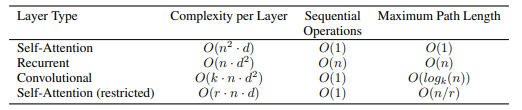

**Первый столбец** означает количество требуемых арифметических операций. Если $n < d$, что является наиболее частым случаем, то self-attention требует меньшего количества операций, чем рекуррентная сеть. Однако квадратичная сложность операции attention в зависимости от длины последовательности $O(n^2 * d)$ становится проблемой при обработке длинных последовательностей. Например, если на входе тысяча векторов, то нужно посчитать миллион скалярных произведений. Авторы высказывают гипотезу о том, что self-attention можно было бы ограничить так, чтобы каждый вектор обменивался информацией только с $r$ ближайшими соседями (последняя строка таблицы). В более новых работах предложены [разреженные трансформеры]($Generating Long Sequences with Sparse Transformers$), в которых вычислительная стоимость операции self-attention уменьшена с $O(n^2)$ до $O(n \sqrt n)$.

Сверточные слои имеют более высокую сложность вычислений $O(k*n*d^2)$, однако с помощью separable convolutions можно уменьшить сложность до $O(k*n*d + n*d^2)$

**Второй столбец** описывает возможность параллелизации, то есть максимальную длину пути между входами и выходами в графе вычислений. Self-attention, как и свертки, хорошо параллелизуется, в отличие от рекуррентных сетей.

**Третий столбец** описывает длину пути в графе вычислений, по которой можно пройти от первого до последнего элемента последовательности (если граф вычислений представить как неориентированный). Авторы называют это "path length between long-range dependencies". Известно, что чем меньше длина такого пути, тем эффективнее сеть обучается, то есть тем легче обнаруживает взаимосвязи между отдаленными элементами в последовательности.

> Learning long-range
dependencies is a key challenge in many sequence transduction tasks. One key factor affecting the
ability to learn such dependencies is the length of the paths forward and backward signals have to
traverse in the network. The shorter these paths between any combination of positions in the input
and output sequences, the easier it is to learn long-range dependencies.

Наконец, авторы высказывают мысль о том, что трансформеры могут оказаться более интерпретируемыми моделями, чем RNN и сверточные сети. "Внимание", направленное от одних элементов последовательности к другим (то есть скалярные произведения этих элементов) легко визуализируются, и выясняется, что отдельные "головы" multi-head attention обучаются искать взаимосвязи разных типов, что авторы показывают на иллюстрациях:

<img src="assets/transformer8.jpg" width="600" align="center">

В последующих работах был проведен более детальный анализ, об этом можно почитать [здесь](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html#analysis_interpretability) и [здесь]($Analyzing Multi-Head Self-Attention: Specialized Heads Do the Heavy Lifting, the Rest Can Be Pruned$).

В ходе экспериментов было обнаружено, что уменьшение размера ключа в self-attention сильно ухудшает производительность, поэтому авторы высказывают гипотезу о том, что поиск векторов, наиболее релевантных данному, не является легкой задачей для сети, поэтому стоит задуматься об использовании более сложной функции, чем скалярное произведение.

В [одной из последующих работ]($Pretrained Transformers as Universal Computation Engines$) было показано, что трансформеры могут претендовать на роль универсальной архитектуры нейронных сетей: обученный на NLP-задаче трансформер с минимальным файн-тюнингом может использоваться и на совсем других задачах, таких как компьютерное зрение и предсказание структуры белка.

### Трансформер без декодера

В оригинальной статье не упоминается трансформер без декодера, однако стоит о нем также кратко упомянуть. В статье [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding]($BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding$) трансформер без декодера обучается либо подставлять пропущенные слова в тексте, либо предсказывать, является ли один кусок текста продолжением другого. Такой подход позволяет обучать трансформер на неразмеченных данных. Полученную модель можно файн-тюнить под широкий класс задач.

Для задачи классификации подаваемое в энкодер предложение начинается со специального токена [CLS]. К выходному вектор энкодера, полученный на данном токене, затем присоединяется полносвязный слой, решающий задачу классификации. Подробнее об этом можно почитать, например, [здесь](https://habr.com/ru/post/487358/).